In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [53]:
rootpath = "KuaiRec 2.0/"

In [72]:
item_daily_features = pd.read_csv(rootpath + "data/item_daily_features.csv")
subset_daily_fts = item_daily_features[["video_id", "show_cnt"]]
subset_daily_fts = subset_daily_fts.groupby("video_id").mean()
subset_daily_fts.head()

,show_cnt
video_id,
0,12791.095238
1,2170.126984
2,10323.444444
3,260.412698
4,15.865385


In [73]:
captions = pd.read_csv(rootpath + "data/kuairec_caption_category_translated.csv")

english_fields = ["english_caption", "english_first_level_category_name", "english_second_level_category_name", "english_third_level_category_name", "english_topic_tag"]
id_field = "video_id"

captions_subset = captions[english_fields + [id_field]]

# Attempt to convert to int, invalid parsing will be set as NaN
captions_subset[id_field] = pd.to_numeric(captions_subset[id_field], errors='coerce')

# Drop rows where conversion failed (i.e., where NaN values are present)
captions_subset = captions_subset.dropna(subset=[id_field])

# Convert to int (after dropping NaNs)
captions_subset[id_field] = captions_subset[id_field].astype(int)

merged = pd.merge(subset_daily_fts, captions_subset, on=id_field, how="inner")

merged.head()

/tmp/ipykernel_1527397/1804644939.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  captions_subset[id_field] = pd.to_numeric(captions_subset[id_field], errors='coerce')


,video_id,show_cnt,english_caption,english_first_level_category_name,english_second_level_category_name,english_third_level_category_name,english_topic_tag
0,0,12791.095238,"The spirit of the young man is tough;程哥, pleas...",Beauty index,Snap of good looks,UNKNOWN,[]
1,1,2170.126984,man,HighTech Digital,UNKNOWN,UNKNOWN,[]
2,2,10323.444444,"After dinner, get some exercise!",Comedy,Humorous interaction,UNKNOWN,[]
3,3,260.412698,"I am unremarkable, unable to stun time or soft...",Photography,Theme Photography,Landscape photography,[]
4,4,15.865385,#Humorous #Thanks快准热浪 #Wulai Market This is a ...,Fashion,Sales promotion,Women's clothing,"[Wulai Market, thanks for Fastly Me Wanting to..."


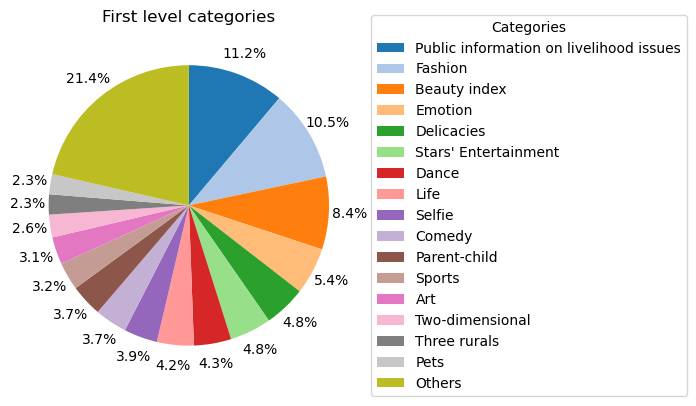

In [4]:
first_level_counts = captions_subset["english_first_level_category_name"].value_counts()
first_level_counts = first_level_counts[first_level_counts >= 0.02 * len(captions_subset)]
first_level_counts["Others"] = len(captions_subset) - first_level_counts.sum()

first_level_counts = first_level_counts.sort_values(ascending=False)

if 'Others' in first_level_counts.index:
    others_value = first_level_counts.pop('Others')
    first_level_counts['Others'] = others_value

colors = plt.get_cmap('tab20').colors

def autopct_outside(pct):
    return ('%.1f%%' % pct) if pct > 0 else ''

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    first_level_counts,
    autopct=autopct_outside,
    colors=colors,
    startangle=90, 
    pctdistance=1.15, 
    counterclock=False
)

ax.legend(
    wedges, first_level_counts.index,
    loc="center left", bbox_to_anchor=(1, 0.5), title="Categories"
)

plt.title("First level categories")
plt.tight_layout()
plt.show()


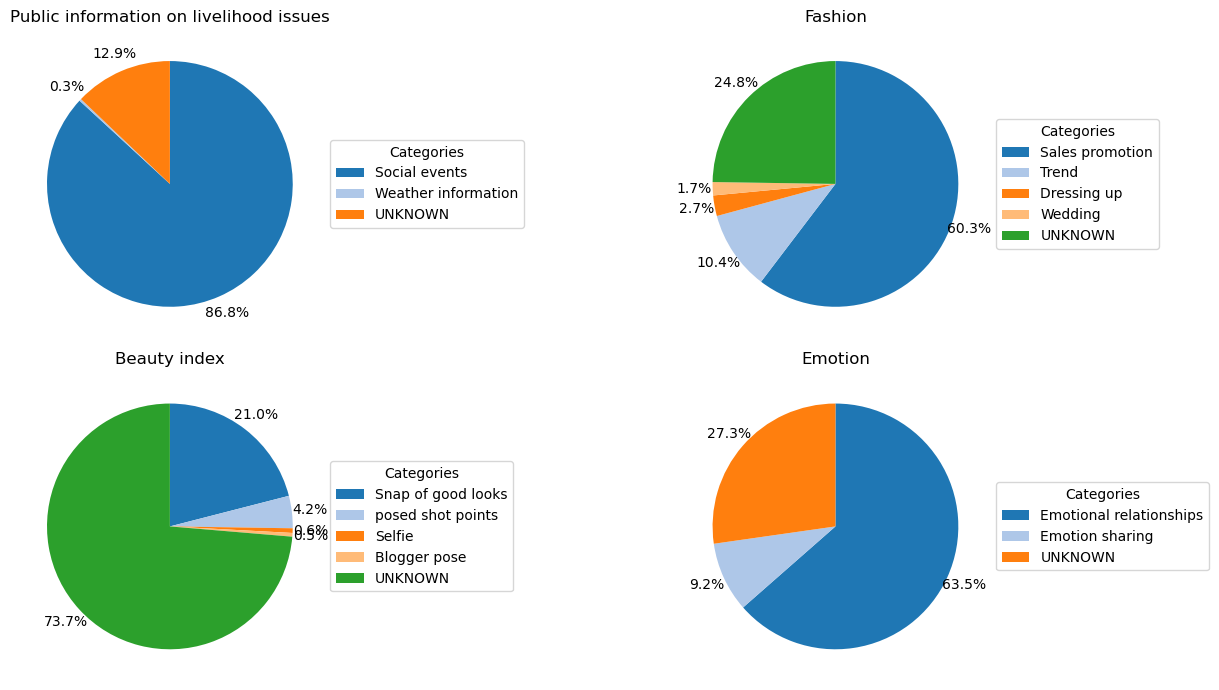

In [5]:
# Show pie charts for second level categories only for the top 4 first level categories
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

for i, category in enumerate(["Public information on livelihood issues", "Fashion", "Beauty index", "Emotion"]):
    second_level_counts = captions_subset[captions_subset["english_first_level_category_name"] == category]["english_second_level_category_name"].value_counts()

    second_level_counts = second_level_counts.sort_values(ascending=False)
    
    # Put UNKNOWN at the end
    if 'UNKNOWN' in second_level_counts.index:
        unknown_value = second_level_counts.pop('UNKNOWN')
        second_level_counts['UNKNOWN'] = unknown_value

    ax = axs[i // 2, i % 2]
    wedges, texts, autotexts = ax.pie(
        second_level_counts,
        autopct=autopct_outside,
        colors=colors,
        startangle=90, 
        pctdistance=1.15, 
        counterclock=False
    )

    ax.set_title(category)
    ax.legend(
        wedges, second_level_counts.index,
        loc="center left", bbox_to_anchor=(1, 0.5), title="Categories"
    )

plt.tight_layout()
plt.show()

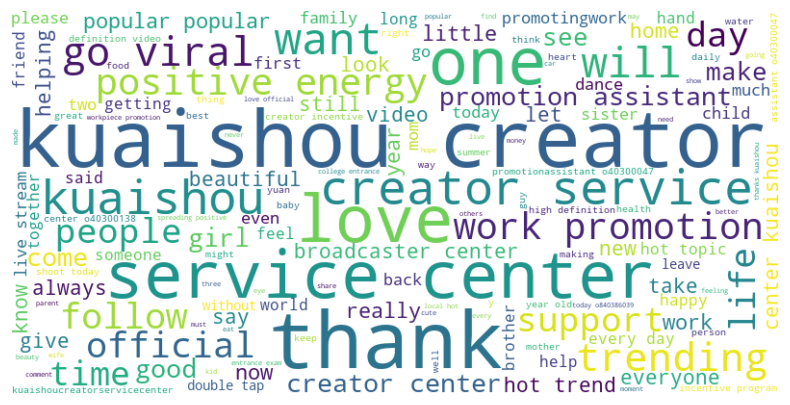

In [14]:
wordcloud = WordCloud(width=800, height=400, background_color ='white', max_words = 150).generate(' '.join(captions_subset["english_caption"]).replace("man", "").lower())
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

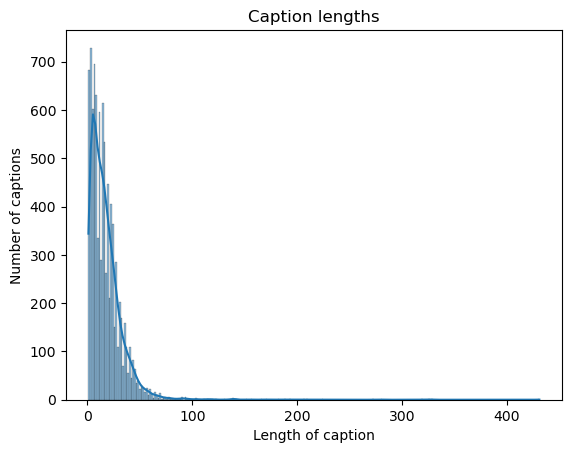

In [39]:
captions_remove_man = captions_subset["english_caption"].apply(lambda x: x.replace("man", ""))
caption_lengths = captions_remove_man.str.split().apply(len)
caption_lengths = caption_lengths[caption_lengths > 0]

sns.histplot(caption_lengths, kde=True)
plt.title("Caption lengths")
plt.xlabel("Length of caption")
plt.ylabel("Number of captions")
plt.show()

In [47]:
all_topic_tags = captions_subset["english_topic_tag"]
all_topic_tags = all_topic_tags[all_topic_tags != "[]"]
all_topic_tags = ["[" + tag + "]" if tag[0] != "[" else tag for tag in all_topic_tags]
all_topic_tags

['[Wulai Market, thanks for Fastly Me Wanting to Be Hot, Funny]',
 '[Liu Yaowen, Song Yaxuan, Wenvxian, and Gu Zixuan are Cherry Ye, with Gu Zixuan super liking Wenvxian.]',
 '[Great Revelation of Soul Attributes]',
 '[Thank Fastly Official for making it popular, thank Promotion Assistant for helping me go viral, give some double taps if you think of the rural folks.]',
 '[Promoting the work, Merchant Campaign Fighting the Epidemic, Thank you Kuaishou for Helping Us Go Viral]',
 "[Official, please provide popular emotional videos. Please don't block them and keep them popular.]",
 '[Thank Fastly Official for the popularity boost, thank Fastly I Want to Be Popular, for boosting immunity, sharing positive energy in parenting, and for promoting growth.]',
 '[Thanks for Fastly Klan helping me go viral, Motorcycle Girl]',
 '[Gemini Deng]',
 '[Three-Cell Special Effect]',
 '[Beautiful Neck Posture, Quick Shadow Subtitles Can Speak, FastHand Full Screen, Seductive Body, I Want to Shine]',
 '[

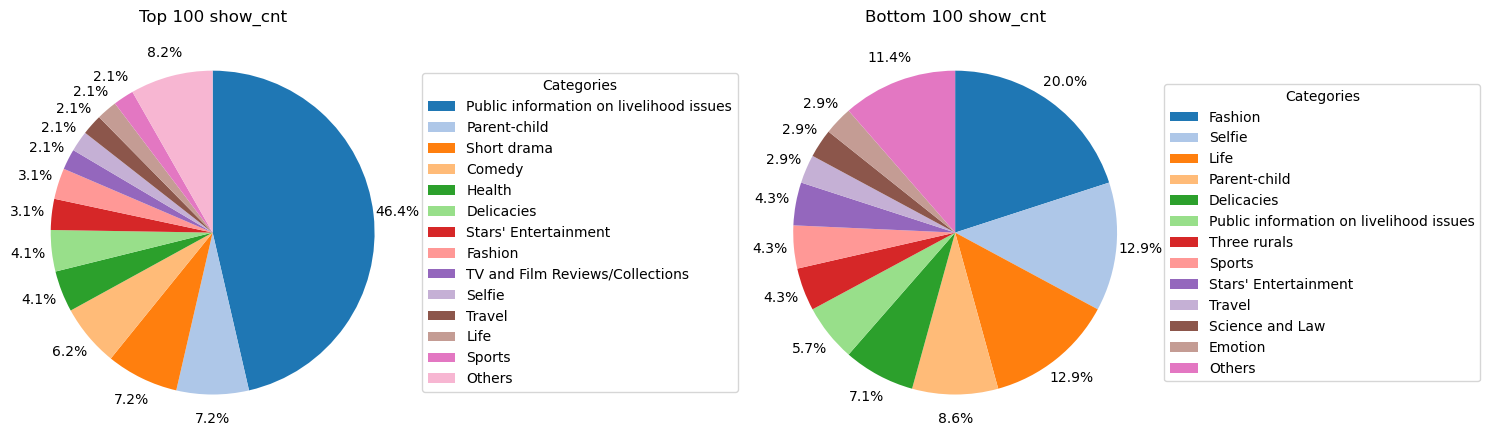

In [77]:
top_100 = subset_daily_fts.sort_values("show_cnt", ascending=False).head(100).index
bottom_100 = subset_daily_fts.sort_values("show_cnt").head(100).index

top_100_merged = merged[merged["video_id"].isin(top_100)]
bottom_100_merged = merged[merged["video_id"].isin(bottom_100)]

top_100_first_level_counts = top_100_merged["english_first_level_category_name"].value_counts()
top_100_first_level_counts = top_100_first_level_counts[top_100_first_level_counts >= 0.02 * len(top_100_merged)]
top_100_first_level_counts["Others"] = len(top_100_merged) - top_100_first_level_counts.sum()
top_100_first_level_counts = top_100_first_level_counts.sort_values(ascending=False)

if 'Others' in top_100_first_level_counts.index:
    others_value = top_100_first_level_counts.pop('Others')
    top_100_first_level_counts['Others'] = others_value

bottom_100_first_level_counts = bottom_100_merged["english_first_level_category_name"].value_counts()
bottom_100_first_level_counts = bottom_100_first_level_counts[bottom_100_first_level_counts >= 0.02 * len(bottom_100_merged)]
bottom_100_first_level_counts["Others"] = len(bottom_100_merged) - bottom_100_first_level_counts.sum()
bottom_100_first_level_counts = bottom_100_first_level_counts.sort_values(ascending=False)

if 'Others' in bottom_100_first_level_counts.index:
    others_value = bottom_100_first_level_counts.pop('Others')
    bottom_100_first_level_counts['Others'] = others_value

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

for i, (first_level_counts, title) in enumerate([(top_100_first_level_counts, "Top 100 show_cnt"), (bottom_100_first_level_counts, "Bottom 100 show_cnt")]):
    ax = axs[i]
    wedges, texts, autotexts = ax.pie(
        first_level_counts,
        autopct=autopct_outside,
        colors=colors,
        startangle=90, 
        pctdistance=1.15, 
        counterclock=False
    )

    ax.set_title(title)
    ax.legend(
        wedges, first_level_counts.index,
        loc="center left", bbox_to_anchor=(1, 0.5), title="Categories"
    )

plt.tight_layout()
plt.show()
